In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA






In [5]:
#Importar paquete nltk para el preprocesamiento de datos por medio de NLP.
import nltk
nltk.download("punkt")
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


NLP sirve para:
*   Eliminar stopwords del texto
*   Obtener una lista de todas las palabras después de eliminar las stopwords.
*   Analizar la frecuencia de palabras y trazar gráfico.


In [6]:
#cargar la base de datos
df= pd.read_csv("spam.csv", encoding='latin-1')
df.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [45]:
df = df.replace(['ham','spam'],[0, 1])
df.head(10)

,class,text
0,0,Go jurong point crazy Available bugis n great ...
1,0,Ok lar Joking wif u oni
2,1,Free entry 2 wkly comp win FA Cup final tkts 2...
3,0,U dun say early hor U c already say
4,0,Nah dont think goes usf lives around though
5,1,FreeMsg Hey darling 3 weeks word back Id like ...
6,0,Even brother like speak treat like aids patent
7,0,per request Melle Melle Oru Minnaminunginte Nu...
8,1,WINNER valued network customer selected receiv...
9,1,mobile 11 months U R entitled Update latest co...


In [47]:

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

#Quitar stopwords y signos de puntuaciön
import string
def text_process(text):

    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return " ".join(text)

df['text'] = df['text'].apply(text_process)

df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,class,text
0,0,Go jurong point crazy Available bugis n great ...
1,0,Ok lar Joking wif u oni
2,1,Free entry 2 wkly comp win FA Cup final tkts 2...
3,0,U dun say early hor U c already say
4,0,Nah dont think goes usf lives around though


In [49]:

text = pd.DataFrame(df['text'])
class1= pd.DataFrame(df['class'])


In [12]:
## Contar las veces que cada palabra aparece en el data set.
from collections import Counter

total_counts = Counter()
for i in range(len(text)):
    for word in text.values[i][0].split(" "):
        total_counts[word] += 1

print("Total words in data set: ", len(total_counts))


Total words in data set:  11305


In [13]:
# clasificar palabras con base a su frecuencia
vocab = sorted(total_counts, key=total_counts.get, reverse=True)
print(vocab[:60])

['u', '2', 'call', 'U', 'get', 'Im', 'ur', '4', 'ltgt', 'know', 'go', 'like', 'dont', 'come', 'got', 'time', 'day', 'want', 'Ill', 'lor', 'Call', 'home', 'send', 'going', 'one', 'need', 'Ok', 'good', 'love', 'back', 'n', 'still', 'text', 'im', 'later', 'see', 'da', 'ok', 'think', 'Ì', 'free', 'FREE', 'r', 'today', 'Sorry', 'week', 'phone', 'mobile', 'cant', 'tell', 'take', 'much', 'night', 'way', 'Hey', 'reply', 'work', 'make', 'give', 'new']


sorted(iterable, /, *, key=None, reverse=False)
Return a new list containing all items from the iterable in ascending order.

A custom key function can be supplied to customize the sort order, and the
reverse flag can be set to request the result in descending order.


In [14]:
# Mapear de aplabras a indices

vocab_size = len(vocab)
word2idx = {}
#print vocab_size
for i, word in enumerate(vocab):
    word2idx[word] = i

In [15]:
# Texto a vector
def text_to_vector(text):
    word_vector = np.zeros(vocab_size)
    for word in text.split(" "):
        if word2idx.get(word) is None:
            continue
        else:
            word_vector[word2idx.get(word)] += 1
    return np.array(word_vector)

In [16]:
# Convertir todas la a vectores
word_vectors = np.zeros((len(text), len(vocab)), dtype=np.int_)
for i, (_, text_) in enumerate(text.iterrows()):
    word_vectors[i] = text_to_vector(text_[0])

word_vectors.shape

(5572, 11305)

In [40]:
#convertir el texto en vectores usado TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df['text'])
vectors.shape
vectors

<5572x9376 sparse matrix of type '<class 'numpy.float64'>'
	with 47254 stored elements in Compressed Sparse Row format>

TDF IDF: Sirve para transformar una matriz de recuento en una representación normalizada tf o tf-idf.

Tf significa término-frecuencia mientras que tf-idf significa término-frecuencia multiplicado por la inversa de la frecuencia del documento. Este es un esquema de ponderación de términos común en la recuperación de información, que también ha encontrado un buen uso en la clasificación de documentos.

El objetivo de usar tf-idf en lugar de las frecuencias de ocurrencia de un token en un documento dado es reducir el impacto de los tokens que ocurren con mucha frecuencia en un set dado y que, por lo tanto, son empíricamente menos informativos que las características que ocurren en un pequeña fracción del set  de entrenamiento.
contar cuantas veces aparece (pero busca su inversa)

In [18]:
#caracteristicas = vectores de palabras
features = vectors

In [19]:
#Dividir el dataset en trainset y testset
X_train, X_test, y_train, y_test = train_test_split(features, df['class'], test_size=0.15, random_state=111)

In [20]:
#Normalizacion para darle el mismo peso a la escala
scaler= StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

min_man_norm = (X - min)/(max - min)
stardard_norm = (X - mean)/sd

In [64]:
#Implementar los modelos de clasificación
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)

svc (Clasificación de vectores de soporte C).

La implementación se basa en libsvm. El tiempo de ajuste escala al menos cuadráticamente con el número de muestras y puede no ser práctico más allá de decenas de miles de muestras.

kernel{'lineal', 'poli', 'rbf', 'sigmoide', 'precalculada'}
Especifica el tipo de kernel que se utilizará en el algoritmo. Si no se proporciona ninguno, se utilizará 'rbf'. el kernel es solo una función que toma dos puntos de datos como entradas y devuelve una puntuación de similitud. Esta similitud puede interpretarse como una métrica de cercanía. Cuanto más cerca estén los puntos de datos, mayor será la similitud..


El algoritmo Multinomial Naive Bayes se utiliza para datos discretos en los que las características representan la frecuencia con la que se han producido ciertos eventos (por ejemplo, el recuento de palabras en un documento).

alphafloat o tipo matriz de forma (n_características), por defecto=1.0. alpha es un hiperparametro, gridseacrh es una forma tradicional de realizar la optimización de hiperparámetros. Funciona buscando exhaustivamente a través de un subconjunto específico de hiperparámetros.




lrc: 'liblinear' se limita a esquemas de uno contra el resto. La elección del algoritmo depende de la penalización elegida. Penalizaciones soportadas por solucionador:
'liblineal' - ['l1']-método de regularización (evitan el overfitting). dividir el peso de la prediccion entre todas las variables.


In [65]:
#hacer una serie con variables de cada modelo.
clfs = {'SVC' : svc,'KN' : knc, "NB" : mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}

In [66]:
# Ajustar los datos a los modelos.
def train(clf, features, targets):
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [67]:
pred_punt_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    pred_punt_word_vectors.append((k, [accuracy_score(y_test , pred)]))

In [68]:
pred_scores_word_vectors

[('SVC', [0.9784688995215312]),
 ('KN', [0.9330143540669856]),
 ('NB', [0.9880382775119617]),
 ('DT', [0.9605263157894737]),
 ('LR', [0.9533492822966507]),
 ('RF', [0.9796650717703349])]

In [69]:
#Funcion para detectar si una palabra o texto puede o no ser spam.
def find(x):
    if x == 1:
        print ("Es SPAM")
    else:
        print ("No es SPAM")

In [74]:
texto_prueba = ["free"]
integers = vectorizer.transform(texto_prueba)

In [75]:
x = mnb.predict(integers)
find(x)

No es SPAM


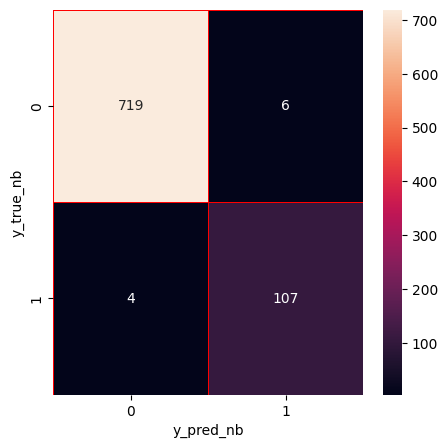

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Naive Bayes
y_pred_nb = mnb.predict(X_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred_nb")
plt.ylabel("y_true_nb")
plt.show()

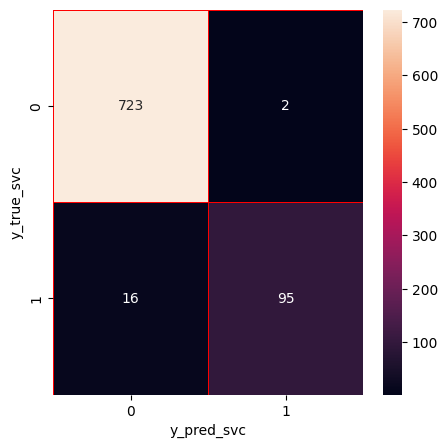

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# SVC
y_pred_svc = svc.predict(X_test)
y_true_svc = y_test
cm = confusion_matrix(y_true_svc, y_pred_svc)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred_svc")
plt.ylabel("y_true_svc")
plt.show()

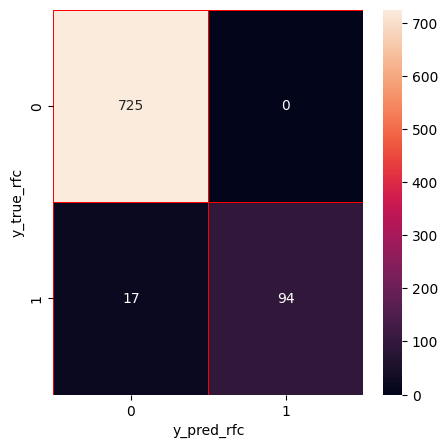

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# RFC
y_pred_rfc = rfc.predict(X_test)
y_true_rfc = y_test
cm = confusion_matrix(y_true_rfc, y_pred_rfc)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred_rfc")
plt.ylabel("y_true_rfc")
plt.show()

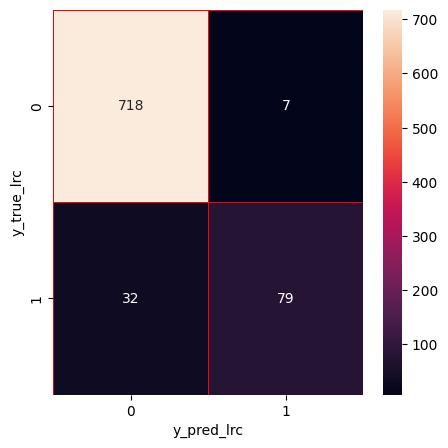

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# KNC
y_pred_lrc = lrc.predict(X_test)
y_true_lrc = y_test
cm = confusion_matrix(y_true_lrc, y_pred_lrc)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred_lrc")
plt.ylabel("y_true_lrc")
plt.show()

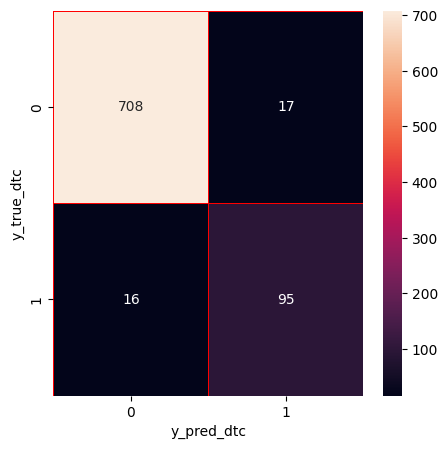

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# dtc
y_pred_dtc = dtc.predict(X_test)
y_true_dtc = y_test
cm = confusion_matrix(y_true_dtc, y_pred_dtc)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred_dtc")
plt.ylabel("y_true_dtc")
plt.show()

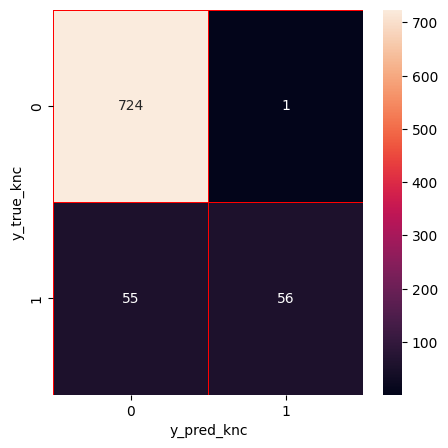

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# KNC
y_pred_knc = knc.predict(X_test)
y_true_knc = y_test
cm = confusion_matrix(y_true_knc, y_pred_knc)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred_knc")
plt.ylabel("y_true_knc")
plt.show()